In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis, Set2 as NodeColors
import math

B-spline as a recursive convolution of the box function:
  https://reproducibility.org/RSF/book/sep/forwd/paper_html/node10.html

B-splines converge to a Gaussian (footnote 8)
    https://bayesiancomputationbook.com/markdown/chp_05.html

Maximum value of a b-spline
    https://mathoverflow.net/questions/254361/maximum-of-a-b-spline



In [2]:
def b0(x):
    """Zero-th order B-spline (box)"""
    x = torch.as_tensor(x)
    return ((-0.5 <= x) & (x < 0.5)).to(x)

def zero(x):
    """Gradient of zero-th order B-spline (zeros)"""
    x = torch.as_tensor(x)
    return torch.zeros_like(x)

def scale_fn(b):
    """Scale a b-spline such that its peak is 1"""
    def newb(x):
        b0 =  b(0)
        y = b(x / b0)
        y /= b0
        return y
    return newb

def make_b(n, scale=False):
    """B-spline function of any order"""
    if n == 0:
        return b0

    bprev = make_b(n-1)

    def bn(x):
        return (bprev(x + 0.5) * (x + (n+1)/2) + bprev(x-0.5) * ((n+1)/2 - x)) / n

    return scale_fn(bn) if scale else bn


def make_g(n, scale=False):
    """Gradient of the B-spline function of any order"""
    if n == 0:
        return zero

    bprev = make_b(n-1)
    gprev = make_g(n-1)

    def gn(x):
        if scale:
            bn0 = make_b(n)(0)
            x = x / bn0
        g = gprev(x + 0.5) * (x + (n+1)/2) + gprev(x-0.5) * ((n+1)/2 - x)
        g += bprev(x + 0.5) - bprev(x-0.5)
        g /= n
        if scale:
            g /= bn0**2
        return g

    return gn


def make_h(n, scale=False):
    """Hessian of the B-spline function of any order"""
    if n == 0:
        return zero

    gprev = make_g(n-1)
    hprev = make_h(n-1)

    def hn(x):
        if scale:
            bn0 = make_b(n)(0)
            x = x / bn0
        h = hprev(x + 0.5) * (x + (n+1)/2) + hprev(x-0.5) * ((n+1)/2 - x)
        h += (gprev(x + 0.5) - gprev(x-0.5)) * 2
        h /= n
        if scale:
            h /= bn0**3
        return h

    return hn

def binf(x):
    """Infinite-order unit-height spline == gaussian"""
    x = torch.as_tensor(x)
    return (- math.pi * x.square()).exp()

def ginf(x):
    """Gradient of the Gaussian"""
    x = torch.as_tensor(x)
    return - 2 * math.pi * x * binf(x)

def hinf(x):
    """Hessian of the Gaussian"""
    x = torch.as_tensor(x)
    return ((2 * math.pi * x).square() - 2 * math.pi) * binf(x)

In [3]:
def b3(x):
    """Non-recursive implementation of cubic spline (for testing)"""
    x = x.abs()
    x_low = (x * x * (x - 2.) * 3. + 4.) / 6.
    x_up = (2. - x) ** 3 / 6.
    return torch.where(x < 1., x_low, x_up).masked_fill_(x > 2, 0)

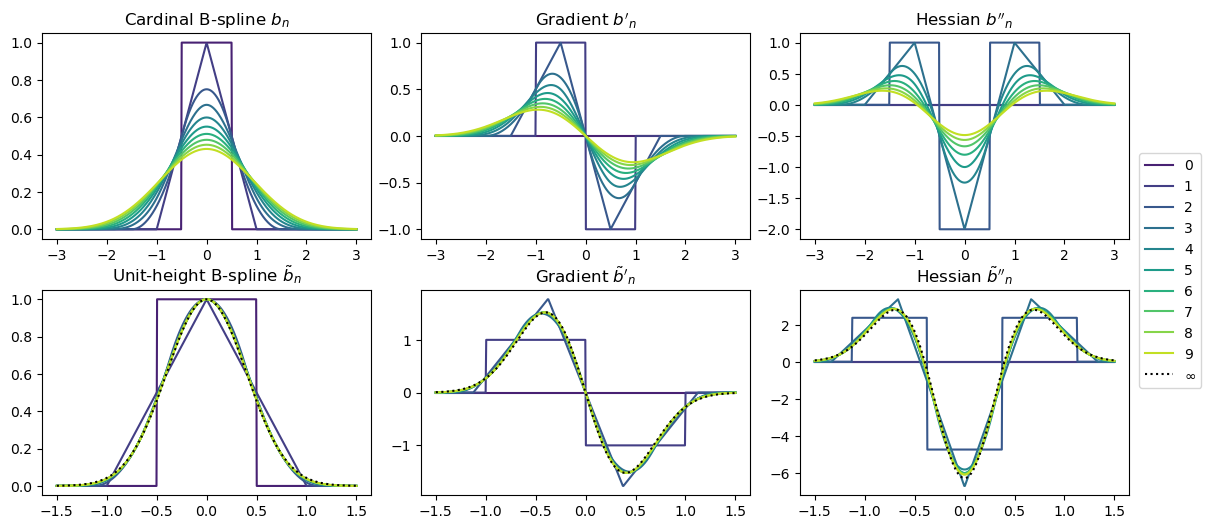

In [4]:
plt.figure(figsize=(15, 6))

nb_order = 10
colors = viridis(torch.linspace(0, 1, nb_order+2))[1:]

x = torch.linspace(-3, 3, 512)

plt.subplot(2, 3, 1)
for n in range(nb_order):
    plt.plot(x, make_b(n)(x), color=colors[n])
# plt.legend(range(nb_order))
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Cardinal B-spline $b_n$")
# plt.plot(x, binf(x), color=colors[-1])

plt.subplot(2, 3, 2)
for n in range(nb_order):
    plt.plot(x, make_g(n)(x), color=colors[n])
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Gradient $b'_n$")
# plt.plot(x, binf(x), color=colors[-1])

plt.subplot(2, 3, 3)
for n in range(nb_order):
    plt.plot(x, make_h(n)(x), color=colors[n])
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Hessian $b''_n$")

x = torch.linspace(-1.5, 1.5, 512)

plt.subplot(2, 3, 4)
for n in range(nb_order):
    plt.plot(x, make_b(n, True)(x), color=colors[n])
plt.plot(x, binf(x), ':k')
plt.gca().set_facecolor('#0F0F0F0F')
plt.legend(list(range(nb_order)) + [r'$\infty$'],
           bbox_to_anchor=(3.54, 1.7))
plt.title(r"Unit-height B-spline $\tilde{b}_n$")

plt.subplot(2, 3, 5)
for n in range(nb_order):
    plt.plot(x, make_g(n, True)(x), color=colors[n])
plt.plot(x, ginf(x), ':k')
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Gradient $\tilde{b}'_n$")

plt.subplot(2, 3, 6)
for n in range(nb_order):
    plt.plot(x, make_h(n, True)(x), color=colors[n])
plt.plot(x, hinf(x), ':k')
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Hessian $\tilde{b}''_n$")

plt.subplots_adjust(right=0.85, wspace=0.15, hspace=0.25)
# plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/bspline.pdf')
plt.show()


In [5]:
# FWHM of unit-height Gaussian
2 * math.sqrt(math.log(2) / math.pi)

0.9394372786996513

In [6]:
def index_dct2(i, n):
    # also: dst2
    i = torch.as_tensor(i)
    n2 = n * 2
    i = torch.where(i < 0, (-i-1).remainder(n2).neg().add(n2 - 1),
                    i.remainder(n2))
    i = torch.where(i >= n, -i + (n2 - 1), i)
    return i

def index_dct1(i, n):
    i = torch.as_tensor(i)
    if n == 1:
        return torch.zeros(i.shape, dtype=i.dtype, device=i.device)
    else:
        n2 = (n - 1) * 2
        i = i.abs().remainder(n2)
        i = torch.where(i >= n, -i + n2, i)


def index_dst1(i, n):
    i = torch.as_tensor(i)
    n2 = 2 * (n + 1)
    first = torch.zeros([1], dtype=i.dtype, device=i.device)
    last = torch.full([1], n - 1, dtype=i.dtype, device=i.device)
    i = torch.where(i < 0, -i - 2, i)
    i = i.remainder(n2)
    i = torch.where(i > n, -i + (n2 - 2), i)
    i = torch.where(i == -1, first, i)
    i = torch.where(i == n, last, i)
    return i

def index_dft(i, n):
    i = torch.as_tensor(i)
    return i.remainder(n)


def sign_dst1(i, n):
    i = torch.as_tensor(i)
    if n == 1:
        return torch.ones_like(i, dtype=torch.int8)
    one = torch.ones([1], dtype=torch.int8, device=i.device)
    zero = torch.zeros([1], dtype=torch.int8, device=i.device)
    n2 = 2 * (n + 1)
    i = torch.where(i < 0, -i + (n-1), i)
    i = i.remainder(n2)
    x = torch.where(i == 0, zero, one)
    x = torch.where(i.remainder(n + 1) == n, zero, x)
    i = torch.floor_divide(i, n+1)
    x = torch.where(torch.remainder(i, 2) > 0, -x, x)
    return x

def sign_dst2(i, n):
    i = torch.as_tensor(i)
    i = torch.where(i < 0, n - 1 - i, i)
    x = torch.ones([1], dtype=torch.int8, device=i.device)
    i = torch.floor_divide(i, n)
    x = torch.where(torch.remainder(i, 2) > 0, -x, x)
    return x

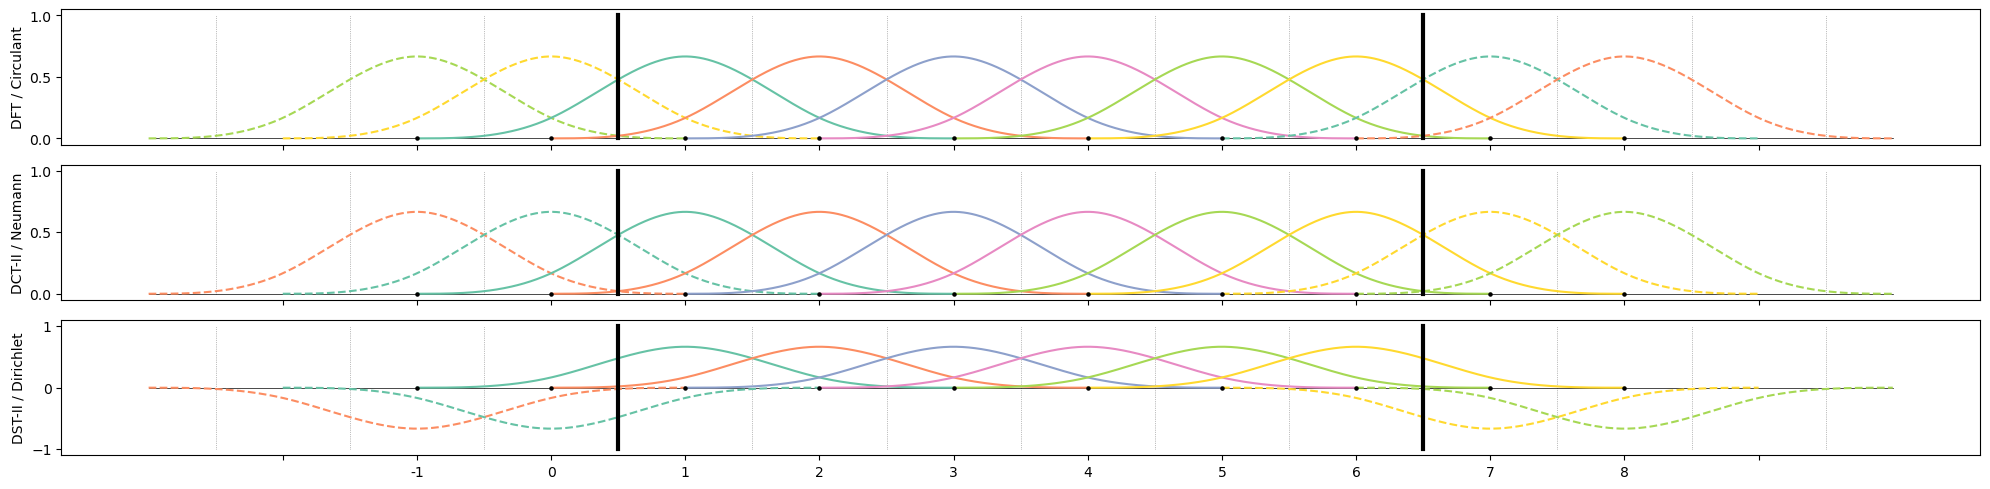

In [9]:
colors = NodeColors(range(6))

plt.figure(figsize=(20, 5))

plt.subplot(3, 1, 1)
plt.plot([-4, 9], [0, 0], 'k', linewidth=0.5)
for i in range(-4, 9):
    i += 0.5
    is_border = i in (-0.5, 5.5)
    plt.plot([i, i], [0, 1],
             '-' if is_border else ':',
             color='black' if is_border else 'gray',
             linewidth=3 if is_border else 0.5,
             zorder=100 if is_border else -1)
for i in range(-2, 8):
    symbol = '-' if i in range(6) else '--'
    x = torch.linspace(i-2, i+2, 512)
    plt.plot(x, b3(x - i), symbol, color=colors[index_dft(i, 6).item()])
for i in range(-2, 8):
    plt.scatter([i], [0], 5, color='black', zorder=100)
plt.xticks(ticks=range(-3, 9), labels=[])
plt.ylabel('DFT / Circulant')

plt.subplot(3, 1, 2)
plt.plot([-4, 9], [0, 0], 'k', linewidth=0.5)
for i in range(-4, 9):
    i += 0.5
    is_border = i in (-0.5, 5.5)
    plt.plot([i, i], [0, 1],
             '-' if is_border else ':',
             color='black' if is_border else 'gray',
             linewidth=3 if is_border else 0.5,
             zorder=100 if is_border else -1)
for i in range(-2, 8):
    symbol = '-' if i in range(6) else '--'
    x = torch.linspace(i-2, i+2, 512)
    plt.plot(x, b3(x - i), symbol, color=colors[index_dct2(i, 6).item()])
for i in range(-2, 8):
    plt.scatter([i], [0], 5, color='black', zorder=100)
plt.xticks(ticks=range(-3, 9), labels=[])
plt.ylabel('DCT-II / Neumann')

plt.subplot(3, 1, 3)
plt.plot([-4, 9], [0, 0], 'k', linewidth=0.5)
for i in range(-4, 9):
    i += 0.5
    is_border = i in (-0.5, 5.5)
    plt.plot([i, i], [-1, 1],
             '-' if is_border else ':',
             color='black' if is_border else 'gray',
             linewidth=3 if is_border else 0.5,
             zorder=100 if is_border else -1)
for i in range(-2, 8):
    flip = sign_dst2(i, 6).item()
    symbol = '-' if i in range(6) else '--'
    x = torch.linspace(i-2, i+2, 512)
    plt.plot(x, b3(x - i) * flip, symbol, color=colors[index_dct2(i, 6).item()])
for i in range(-2, 8):
    plt.scatter([i], [0], 5, color='black', zorder=100)
plt.xticks(ticks=range(-3, 9), labels=[''] + list(range(-1, 9)) + [''])
plt.ylabel('DST-II / Dirichlet')

plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/bounds.pdf')
plt.show()

In [56]:
import sympy

x = sympy.Symbol('x', real=True)
half = sympy.S.Half

symb0 = sympy.Piecewise((0, x < -half), (1, x < half), (0, True))
"""Zero-th order B-spline (box)"""


def call(f, val):
    """Evaluate a symbolic function"""
    return f.subs(x, val)


def make_symb(n):
    """B-spline of any order"""
    if n == 0:
        return symb0

    bprev = make_symb(n-1)
    halflength = (n + 1) * half
    return sympy.simplify((
        call(bprev, x + half) * (halflength + x) +
        call(bprev, x - half) * (halflength - x)
    ) / n)


def make_symg(n):
    """Gradient of the B-spline of any order"""
    if n == 0:
        return sympy.S('0')

    bprev = make_symb(n-1)
    gprev = make_symg(n-1)
    halflength = (n + 1) * half
    return sympy.simplify((
        call(gprev, x + half) * (halflength + x) +
        call(gprev, x - half) * (halflength - x) +
        call(bprev, x + half) - call(bprev, x - half)
    ) / n)


def make_symh(n):
    """Hessian of the B-spline of any order"""
    if n == 0:
        return sympy.S('0')

    gprev = make_symg(n-1)
    hprev = make_symh(n-1)
    halflength = (n + 1) * half
    return sympy.simplify((
        call(hprev, x + half) * (halflength + x) +
        call(hprev, x - half) * (halflength - x) +
        (call(gprev, x + half) - call(gprev, x - half)) * 2
    ) / n)


def product(f, g):
    """Symbolic product between two piecewise functions

    SymPy struggles with such products, so we implement our own version
    (which has a bunch of assumptions on the piecewise structure of f and g,
    so do not use this function in the wild! in particular we asssume that all
    piecewise conditions are of the form "x < number")
    """
    fargs, gargs = list(f.args), list(g.args)
    args = []
    while True:
        if fargs and isinstance(fargs[0][1], sympy.StrictLessThan):
            farg = (fargs[0][0], sympy.simplify(fargs[0][1]))
            flim = int(farg[1].args[1])
            if gargs and isinstance(gargs[0][1], sympy.StrictLessThan):
                garg = (gargs[0][0], sympy.simplify(gargs[0][1]))
                glim = int(garg[1].args[1])
                if flim < glim:
                    arg = (farg[0] * garg[0], farg[1])
                    if args and arg[0] == args[-1][0]:
                        args.pop(-1)
                    args.append(arg)
                    fargs.pop(0)
                    continue
                if glim < flim:
                    arg = (farg[0] * garg[0], garg[1])
                    if args and arg[0] == args[-1][0]:
                        args.pop(-1)
                    args.append(arg)
                    gargs.pop(0)
                    continue
                assert flim == glim
                arg = (farg[0] * garg[0], farg[1])
                if args and arg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(arg)
                fargs.pop(0)
                gargs.pop(0)
                continue
            elif gargs:
                arg = (farg[0] * gargs[0][0], farg[1])
                if args and arg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(arg)
                fargs.pop(0)
                continue
            else:
                if args and farg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(farg)
                fargs.pop(0)
                continue
        elif gargs and isinstance(gargs[0][1], sympy.StrictLessThan):
            garg = (gargs[0][0], sympy.simplify(gargs[0][1]))
            if fargs:
                arg = (fargs[0][0] * garg[0], garg[1])
                if args and arg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(arg)
                gargs.pop(0)
                continue
            else:
                if args and garg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(garg)
                gargs.pop(0)
                continue
        elif fargs and gargs:
            arg = (fargs[0][0] * gargs[0][0], fargs[0][1])
            if args and arg[0] == args[-1][0]:
                args.pop(-1)
            args.append(arg)
            fargs.pop(0)
            gargs.pop(0)
            continue
        elif fargs:
            if args and fargs[0][0] == args[-1][0]:
                args.pop(-1)
            args.append(fargs.pop(0))
            continue
        elif gargs:
            if args and gargs[0][0] == args[-1][0]:
                args.pop(-1)
            args.append(gargs.pop(0))
            continue
        break
    return sympy.Piecewise(*args)


def corr(i, n, f, g=None):
    """Evaluate (f * g)(i)   (correlation integrated on [-n, n])"""
    if g is None:
        g = f
    f = sympy.simplify(f)
    g = sympy.simplify(g)
    gshift = call(g, x - i)
    fg = product(f, gshift)
    fg = sympy.simplify(fg)
    return sympy.integrate(fg, (x, -n, n))


# compute autocorrelations at integer locations
for n in range(0):
    print(f'--- order {n} ---')
    f, ff = make_symb(n), []
    print('ff = [', end='', flush=True)
    for i in range(-n, n+1):
        ff += [corr(i, n, f)]
        print(ff[-1], end=', ' if i < n else ']\n', flush=True)
    if n < 1: continue
    g, gg = make_symg(n), []
    print('gg = [', end='', flush=True)
    for i in range(-n, n+1):
        gg += [corr(i, n, g)]
        print(gg[-1], end=', ' if i < n else ']\n', flush=True)
    fg = []
    print('fg = [', end='', flush=True)
    for i in range(-n, n+1):
        fg += [corr(i, n, f, g)]
        print(fg[-1], end=', ' if i < n else ']\n', flush=True)
    if n < 2: continue
    h, hh = make_symh(n), []
    print('hh = [', end='', flush=True)
    for i in range(-n, n+1):
        hh += [corr(i, n, h)]
        print(hh[-1], end=', ' if i < n else ']\n', flush=True)
print('')

# compute spline coefficients at integer locations
for n in range(8):
    print(f'--- order {n} ---')
    f, ff = make_symb(n), []
    print('f  = [', end='', flush=True)
    for i in range(0, (n+2)//2):
        ff += [call(f, i)]
        print(ff[-1], end=', ' if i < (n+2)//2-1 else ']\n', flush=True)
    fullf = ff[1:][::-1] + ff
    print('ff = [', end='', flush=True)
    for i in reversed(range(1, len(fullf)+1)):
        c = sum(a*b for a, b in zip(fullf[:i], fullf[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)
    if n < 1: continue
    g, gg = make_symg(n), []
    print('g  = [', end='', flush=True)
    for i in range(0, (n+2)//2):
        gg += [call(g, i)]
        print(gg[-1], end=', ' if i < (n+2)//2-1 else ']\n', flush=True)
    fullg = [-foo for foo in gg[1:][::-1]] + gg
    print('gg = [', end='', flush=True)
    for i in reversed(range(1, len(fullg)+1)):
        c = sum(a*b for a, b in zip(fullg[:i], fullg[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)
    print('fg = [', end='', flush=True)
    for i in reversed(range(1, len(fullg)+1)):
        c = sum(a*b for a, b in zip(fullf[:i], fullg[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)
    if n < 2: continue
    h, hh = make_symh(n), []
    print('h  = [', end='', flush=True)
    for i in range(0, (n+2)//2):
        hh += [call(h, i)]
        print(hh[-1], end=', ' if i < (n+2)//2-1 else ']\n', flush=True)
    fullh = hh[1:][::-1] + hh
    print('hh = [', end='', flush=True)
    for i in reversed(range(1, len(fullh)+1)):
        c = sum(a*b for a, b in zip(fullh[:i], fullh[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)



--- order 0 ---
f  = [1]
ff = [1]
--- order 1 ---
f  = [1]
ff = [1]
g  = [-1]
gg = [1]
fg = [-1]
--- order 2 ---
f  = [3/4, 1/8]
ff = [19/32, 3/16, 1/64]
g  = [0, -1/2]
gg = [1/2, 0, -1/4]
fg = [0, -3/8, -1/16]
h  = [-2, 1]
hh = [6, -4, 1]
--- order 3 ---
f  = [2/3, 1/6]
ff = [1/2, 2/9, 1/36]
g  = [0, -1/2]
gg = [1/2, 0, -1/4]
fg = [0, -1/3, -1/12]
h  = [-2, 1]
hh = [6, -4, 1]
--- order 4 ---
f  = [115/192, 19/96, 1/384]
ff = [32227/73728, 1463/6144, 1559/36864, 19/18432, 1/147456]
g  = [0, -11/24, -1/48]
gg = [485/1152, 11/576, -121/576, -11/576, -1/2304]
fg = [0, -2557/9216, -317/3072, -49/9216, -1/18432]
h  = [-5/4, 1/2, 1/8]
hh = [67/32, -9/8, -1/16, 1/8, 1/64]
--- order 5 ---
f  = [11/20, 13/60, 1/120]
ff = [571/1440, 871/3600, 101/1800, 13/3600, 1/14400]
g  = [0, -5/12, -1/24]
gg = [101/288, 5/144, -25/144, -5/144, -1/576]
fg = [0, -169/720, -163/1440, -1/80, -1/2880]
h  = [-1, 1/3, 1/6]
hh = [23/18, -5/9, -2/9, 1/9, 1/36]
--- order 6 ---
f  = [5887/11520, 10543/46080, 361/23040

In [64]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis, Set2 as NodeColors
import torch
from scipy.ndimage import spline_filter, zoom
from interpol.regularizers import flowreg, make_evalkernels1d
from interpol import resize, spline_coeff_nd

BOUND = 'circulant'
ANCHOR = 'edge'
ORDER = 3
NORM = True
SHAPE = 16
MAXFAC = 6
USE_SCIPY = False

# sample spline coefficients on a coarse grid
coeff = torch.randn(SHAPE, SHAPE, 2, dtype=torch.float64)

# coarse to fine pyramid of grids
factors = torch.linspace(0, MAXFAC, 32).tolist()
shapes = [int(round(SHAPE * 2**f)) for f in factors]
# I make it so the voxel size is 1 when the grid is 128, because of
# instabilities obsered when working with tiny voxel sizes (I think
# when taking 1/vx**2 during scaling of the derivatives)
vxs = [2 * 128 / round(SHAPE * 2**f) for f in factors]
print(shapes)
print(vxs)

absolute_exact, absolute_approx, absolute_fd = [], [], []
membrane_exact, membrane_approx, membrane_fd = [], [], []
bending_exact, bending_approx, bending_fd = [], [], []
div_exact, div_approx, div_fd = [], [], []

for shape, vx in zip(shapes, vxs):
    if USE_SCIPY:
        # To check if the downtick observed when resampling to a coarse
        # grid is caused by my interpolation code, I tried using pure
        # scipy instead, but found the same effect
        flow1 = torch.stack([
            torch.as_tensor(zoom(c, shape/SHAPE, order=ORDER, grid_mode=True,
                                mode='grid-wrap' if BOUND == 'circulant' else 'grid-mirror'))
            for c in coeff.unbind(-1)
        ], -1).mul_(shape/SHAPE)
        coeff1 = torch.stack([
            torch.as_tensor(spline_filter(f, ORDER, mode='grid-wrap' if BOUND == 'circulant' else 'grid-mirror'))
            for f in flow1.unbind(-1)
        ], -1)
    else:
        # This uses torch-interpol instead of scipy.ndimage
        flow1 = resize(
            coeff.movedim(-1, 0), shape=[shape]*2,
            anchor=ANCHOR, interpolation=ORDER, prefilter=False, bound=BOUND
        ).movedim(0, -1).mul_(shape/SHAPE)
        coeff1 = coeff
        if shape != SHAPE:
            coeff1 = spline_coeff_nd(
                flow1.movedim(-1, 0), interpolation=ORDER, bound=BOUND, dim=2
            ).movedim(0, -1)
    # compute energies
    absolute_exact += [flowreg(coeff1, ORDER, bound=BOUND, absolute=1, norm=NORM, voxel_size=vx)]
    membrane_exact += [flowreg(coeff1, ORDER, bound=BOUND, membrane=1, norm=NORM, voxel_size=vx)]
    bending_exact += [flowreg(coeff1, ORDER, bound=BOUND, bending=1, norm=NORM, voxel_size=vx)]
    div_exact += [flowreg(coeff1, ORDER, bound=BOUND, div=1, norm=NORM, voxel_size=vx)]
    absolute_approx += [flowreg(coeff1, ORDER, bound=BOUND, absolute=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    membrane_approx += [flowreg(coeff1, ORDER, bound=BOUND, membrane=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    bending_approx += [flowreg(coeff1, ORDER, bound=BOUND, bending=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    div_approx += [flowreg(coeff1, ORDER, bound=BOUND, div=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    absolute_fd += [flowreg(flow1, 'fd', bound=BOUND, absolute=1, norm=NORM, voxel_size=vx)]
    membrane_fd += [flowreg(flow1, 'fd', bound=BOUND, membrane=1, norm=NORM, voxel_size=vx)]
    bending_fd += [flowreg(flow1, 'fd', bound=BOUND, bending=1, norm=NORM, voxel_size=vx)]
    div_fd += [flowreg(flow1, 'fd', bound=BOUND, div=1, norm=NORM, voxel_size=vx)]

[16, 18, 21, 24, 27, 31, 36, 41, 47, 54, 61, 70, 80, 92, 105, 120, 137, 157, 179, 205, 234, 268, 306, 350, 400, 458, 524, 599, 685, 783, 895, 1024]
[16.0, 14.222222222222221, 12.19047619047619, 10.666666666666666, 9.481481481481481, 8.258064516129032, 7.111111111111111, 6.2439024390243905, 5.446808510638298, 4.7407407407407405, 4.19672131147541, 3.657142857142857, 3.2, 2.782608695652174, 2.4380952380952383, 2.1333333333333333, 1.8686131386861313, 1.6305732484076434, 1.4301675977653632, 1.248780487804878, 1.0940170940170941, 0.9552238805970149, 0.8366013071895425, 0.7314285714285714, 0.64, 0.5589519650655022, 0.48854961832061067, 0.4273789649415693, 0.37372262773722625, 0.3269476372924649, 0.2860335195530726, 0.25]


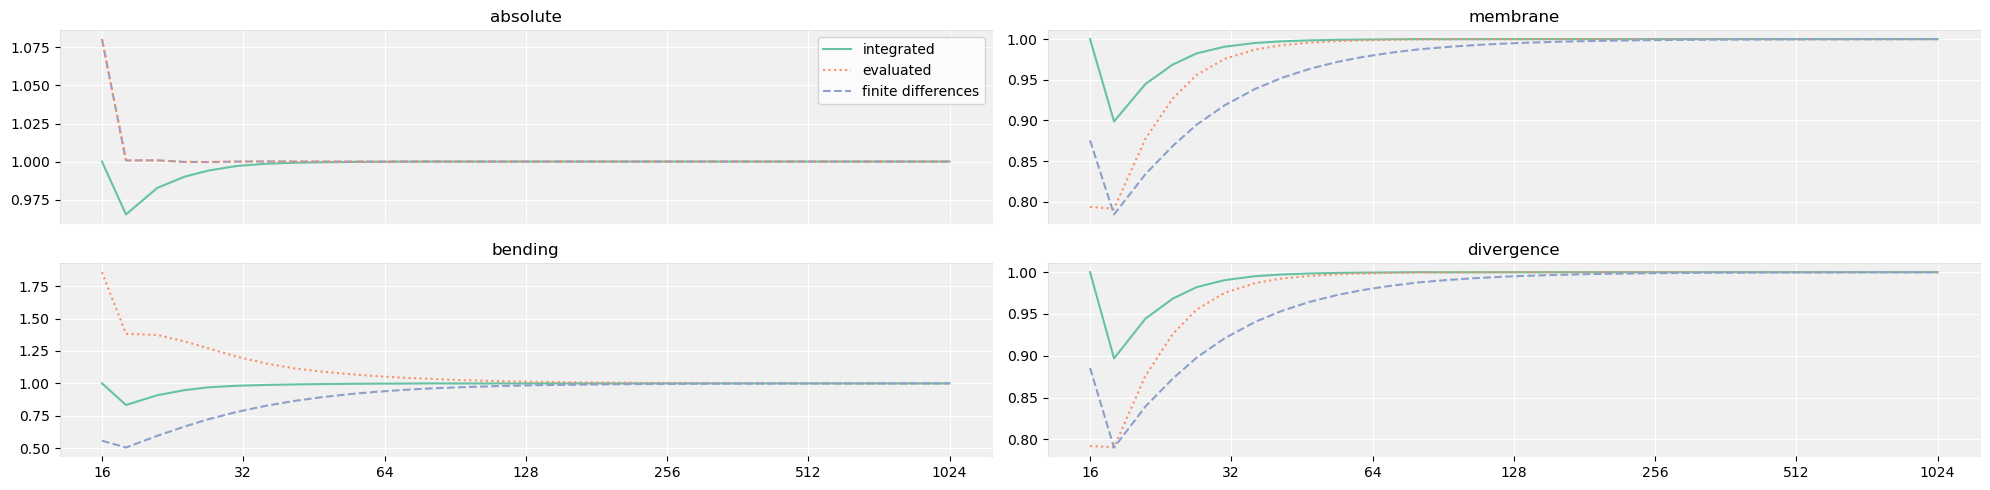

In [67]:

plt.figure(figsize=(20, 5))
colors = NodeColors(range(4))

# plt.set_cmap()
plt.subplot(2, 2, 1)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / absolute_exact[0], absolute_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / absolute_exact[0], absolute_approx)), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / absolute_exact[0], absolute_fd)), '--', color=colors[2])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.gca().tick_params(axis='x', color='w')
plt.minorticks_off()
plt.legend(['integrated', 'evaluated', 'finite differences'])
plt.title('absolute')
plt.subplot(2, 2, 2)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / membrane_exact[0], membrane_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / membrane_exact[0], membrane_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / membrane_exact[0], membrane_fd)), '--', color=colors[2])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.gca().tick_params(axis='x', color='w')
plt.minorticks_off()
plt.title('membrane')
plt.subplot(2, 2, 3)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / bending_exact[0], bending_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / bending_exact[0], bending_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / bending_exact[0], bending_fd)), '--', color=colors[2])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('bending')
plt.subplot(2, 2, 4)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / div_exact[0], div_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / div_exact[0], div_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / div_exact[0], div_fd)), '--', color=colors[2])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('divergence')


plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/errors.pdf')
plt.show()